# NER(네이버 개체명 인식) 데이터 분석
- 감정분류 및 유사도 문제는 마지막 히든 벡터값만 이용했다면, 개체명 인식에선 문장의 모든 입력을 개체명으로 예측해야하므로 모든 은닉벡터값을 활용함

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer

In [2]:
# 데이터 불러오기
DATA_IN_PATH = 'data_in/KOR'
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv") # 81000개
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv") # 9000개
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")

In [3]:
# 한국어 개체명 데이터는 판다스로 불러오면 따옴표 등의 이슈로 전체 데이터 81000개에서 약 740000개로 감소함
# 탭으로 나눠져 있으므로 반복문을 통해 매 라인을 불러옴
def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, 'r', encoding='utf-8') as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split('\t')
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels
    
train_sentences, train_labels = read_file(DATA_TRAIN_PATH)
test_sentences, test_labels = read_file(DATA_TEST_PATH)
ner_sentences = train_sentences + test_sentences
ner_labels = train_labels + test_labels

ner_dict = {"sentence": ner_sentences, "label": ner_labels}
ner_df = pd.DataFrame(ner_dict)

In [5]:
ner_df.head()

,sentence,label
0,"금석객잔 여러분, 감사드립니다 .",ORG-B O O O
1,이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .,PER-B O O O TIM-B TIM-I CVL-B O O O O O
2,7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...,EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O
3,스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...,LOC-B NUM-B NUM-I O O O O O O O O O O O O O CV...
4,보니까 저 옆에 사조가 있어요 .,O O O O O O


In [6]:
print('전체 ner_data 개수: {}'.format(len(ner_df)))

전체 ner_data 개수: 90000


In [7]:
train_set = pd.Series(ner_df["sentence"].tolist())
print('유일한 총 문장 수 : {}'.format(len(np.unique(train_set))))
print('반복해서 나타나는 문장의 수: {}'.format(np.sum(train_set.value_counts() > 1)))


유일한 총 문장 수 : 88703
반복해서 나타나는 문장의 수: 288


/Users/ohyeji/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Number of sentence')

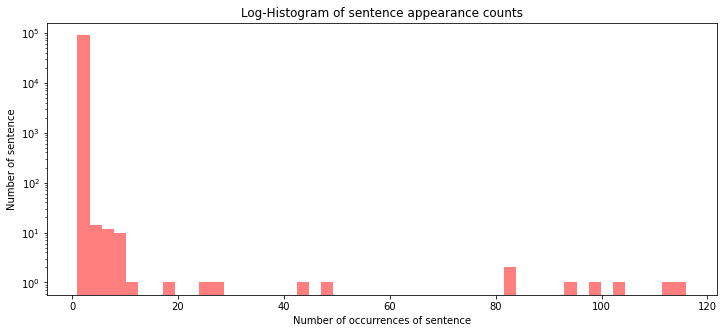

In [8]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_set.value_counts(), bins=50, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of sentence appearance counts')
# 그래프 x 축 라벨
plt.xlabel('Number of occurrences of sentence')
# 그래프 y 축 라벨
plt.ylabel('Number of sentence')

In [9]:
print('중복 최대 개수: {}'.format(np.max(train_set.value_counts())))
print('중복 최소 개수: {}'.format(np.min(train_set.value_counts())))
print('중복 평균 개수: {:.2f}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차: {:.2f}'.format(np.std(train_set.value_counts())))
print('중복 중간길이: {}'.format(np.median(train_set.value_counts())))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 25)))
print('제 3 사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 75)))

중복 최대 개수: 116
중복 최소 개수: 1
중복 평균 개수: 1.01
중복 표준편차: 0.92
중복 중간길이: 1.0
제 1 사분위 중복: 1.0
제 3 사분위 중복: 1.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1a1bed1f60>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1bede550>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1bed1cf8>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1bedeb00>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1beeb048>],
 'means': [<matplotlib.lines.Line2D at 0x1a1bededd8>]}

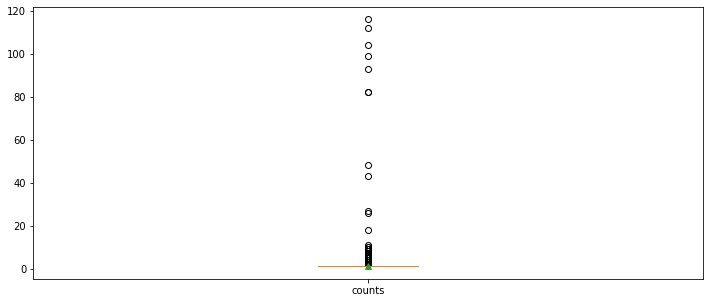

In [10]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot([train_set.value_counts()],
             labels=['counts'],
             showmeans=True)

## 문장 길이 분석

In [11]:
train_length = train_set.apply(len)

In [12]:
train_length

0         18
1         39
2         60
3        125
4         18
        ... 
89995     19
89996     62
89997     22
89998     54
89999     50
Length: 90000, dtype: int64

In [13]:
print('문장 길이 최대 값: {}'.format(np.max(train_length)))
print('문장 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('문장 길이 중간 값: {}'.format(np.median(train_length)))
print('문장 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('문장 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

문장 길이 최대 값: 1162
문장 길이 평균 값: 50.90
문장 길이 표준편차: 34.15
문장 길이 중간 값: 43.0
문장 길이 제 1 사분위: 29.0
문장 길이 제 3 사분위: 63.0


Text(0, 0.5, 'Probability')

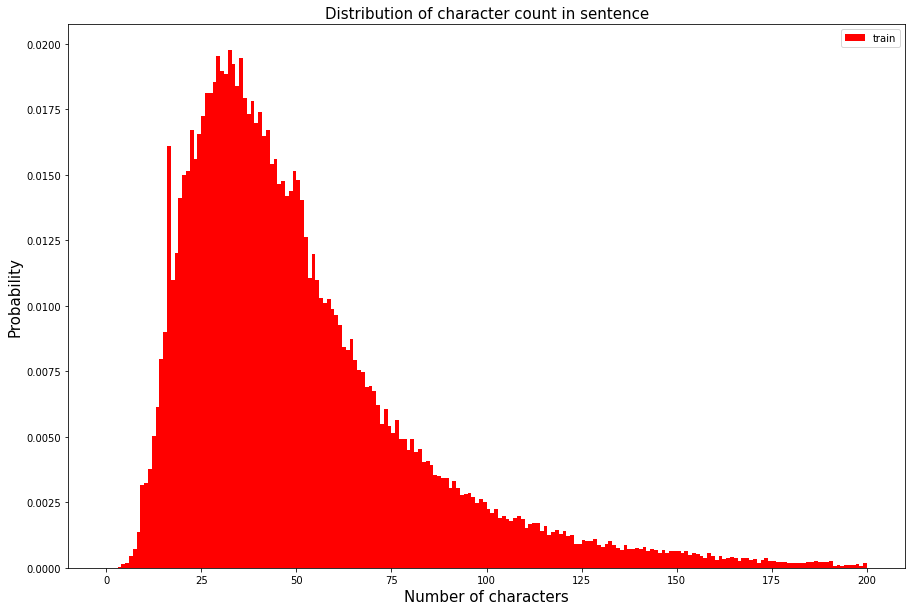

In [14]:
plt.figure(figsize=(15, 10))
plt.hist(train_length, bins=200, range=[0,200], facecolor='r', density=True, label='train')
plt.title("Distribution of character count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

{'whiskers': [<matplotlib.lines.Line2D at 0x1a1c331cc0>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1c39c978>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1c2a1dd8>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1c6f3ef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1c2d92e8>],
 'means': [<matplotlib.lines.Line2D at 0x1a1c86fe80>]}

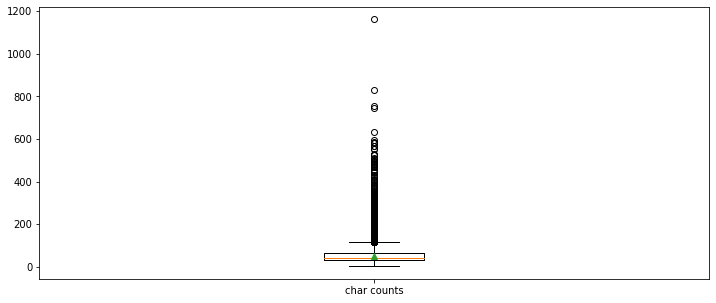

In [15]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_length,
             labels=['char counts'],
             showmeans=True)

## 단어 개수 분석 (띄어쓰기 기준)

In [16]:
train_word_counts = train_set.apply(lambda x:len(x.split(' ')))

print('문장 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('문장 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('문장 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('문장 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
print('문장 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('문장 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))
print('문장 단어 개수 99 퍼센트: {}'.format(np.percentile(train_word_counts, 99)))

# 문장 단어 개수 최대 값: 175
# 문장 단어 개수 평균 값: 11.81
# 문장 단어 개수 표준편차: 7.03
# 문장 단어 개수 중간 값: 10.0
# 문장 단어 개수 제 1 사분위: 7.0
# 문장 단어 개수 제 3 사분위: 15.0
# 문장 단어 개수 99 퍼센트: 35.0

문장 단어 개수 최대 값: 175
문장 단어 개수 평균 값: 11.82
문장 단어 개수 표준편차: 7.03
문장 단어 개수 중간 값: 10.0
문장 단어 개수 제 1 사분위: 7.0
문장 단어 개수 제 3 사분위: 15.0
문장 단어 개수 99 퍼센트: 35.0


Text(0, 0.5, 'Probability')

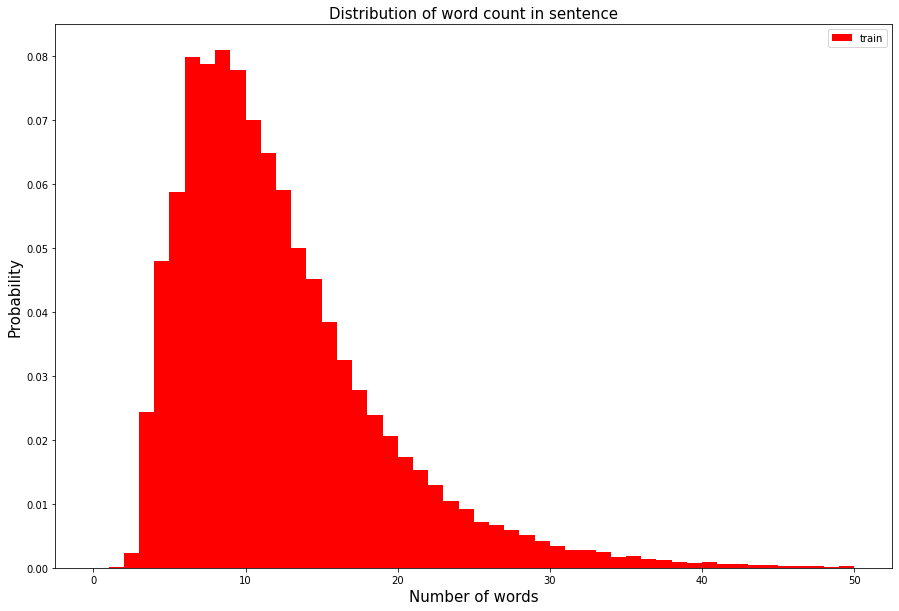

In [19]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, range=[0, 50], facecolor='r', density=True, label='train')
plt.title('Distribution of word count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

{'whiskers': [<matplotlib.lines.Line2D at 0x1a1c7a7898>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1c7a7e48>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1c7a7630>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1c7b6438>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1c7b6908>],
 'means': [<matplotlib.lines.Line2D at 0x1a1c7b6710>]}

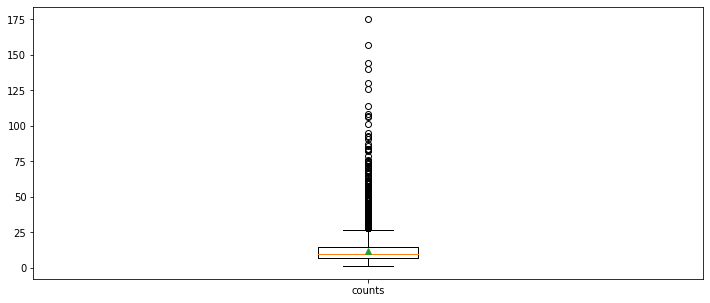

In [20]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_word_counts,
             labels=['counts'],
             showmeans=True)

## 특수 기호 분석 

In [21]:
qmarks = np.mean(train_set.apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
math = np.mean(train_set.apply(lambda x: '[math]' in x)) # []
fullstop = np.mean(train_set.apply(lambda x: '.' in x)) # 마침표
capital_first = np.mean(train_set.apply(lambda x: x[0].isupper())) #  첫번째 대문자
capitals = np.mean(train_set.apply(lambda x: max([y.isupper() for y in x]))) # 대문자가 몇개
numbers = np.mean(train_set.apply(lambda x: max([y.isdigit() for y in x]))) # 숫자가 몇개
                  
print('물음표가있는 문장: {:.2f}%'.format(qmarks * 100))
print('수학 태그가있는 문장: {:.2f}%'.format(math * 100))
print('마침표를 포함한 문장: {:.2f}%'.format(fullstop * 100))
print('첫 글자가 대문자 인 문장: {:.2f}%'.format(capital_first * 100))
print('대문자가있는 문장: {:.2f}%'.format(capitals * 100))
print('숫자가있는 문장: {:.2f}%'.format(numbers * 100))

물음표가있는 문장: 2.24%
수학 태그가있는 문장: 0.00%
마침표를 포함한 문장: 84.92%
첫 글자가 대문자 인 문장: 2.87%
대문자가있는 문장: 16.65%
숫자가있는 문장: 41.61%


## Tokenizer cased (버트 토크나이저)

In [22]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", 
                                          cache_dir='bert_ckpt', 
                                          do_lower_case=False)

In [23]:
train_bert_token_counts = train_set.apply(lambda x:len(tokenizer.tokenize(x)))

Text(0, 0.5, 'Probability')

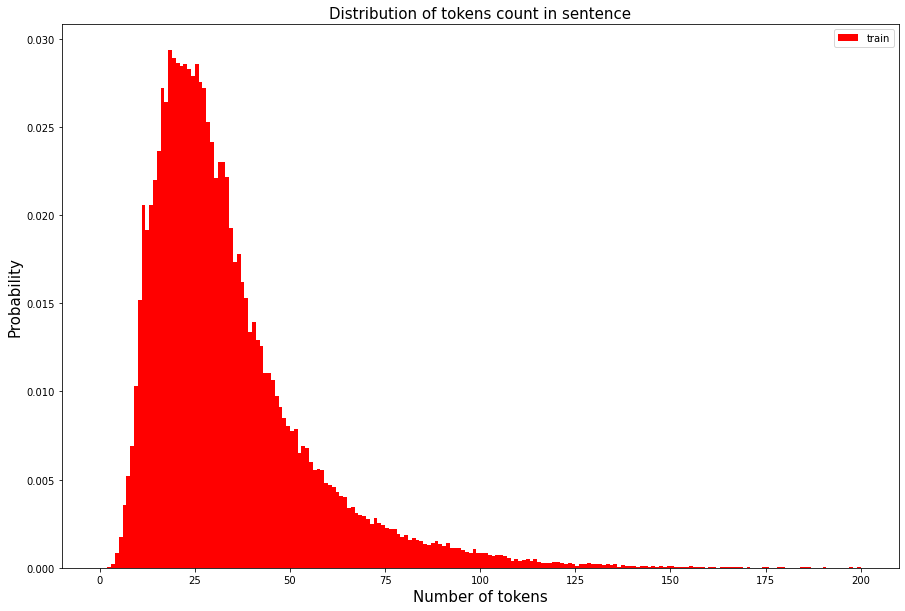

In [24]:
plt.figure(figsize=(15, 10))
plt.hist(train_bert_token_counts, bins=200, range=[0, 200], facecolor='r', density=True, label='train')
plt.title('Distribution of tokens count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of tokens', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [25]:
print('문장 tokens 개수 최대 값: {}'.format(np.max(train_bert_token_counts)))
print('문장 tokens 개수 평균 값: {:.2f}'.format(np.mean(train_bert_token_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_counts)))
print('문장 tokens 개수 중간 값: {}'.format(np.median(train_bert_token_counts)))
print('문장 tokens 개수 제 1 사분위: {}'.format(np.percentile(train_bert_token_counts, 25)))
print('문장 tokens 개수 제 3 사분위: {}'.format(np.percentile(train_bert_token_counts, 75)))
print('문장 tokens 개수 99 퍼센트: {}'.format(np.percentile(train_bert_token_counts, 99)))

문장 tokens 개수 최대 값: 850
문장 tokens 개수 평균 값: 33.62
문장 tokens 개수 표준편차: 22.76
문장 tokens 개수 중간 값: 28.0
문장 tokens 개수 제 1 사분위: 19.0
문장 tokens 개수 제 3 사분위: 41.0
문장 tokens 개수 99 퍼센트: 111.0


{'whiskers': [<matplotlib.lines.Line2D at 0x1a1c420f98>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1c4219b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1c2f6f98>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1c421f60>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1c4562b0>],
 'means': [<matplotlib.lines.Line2D at 0x1a1c3bcac8>]}

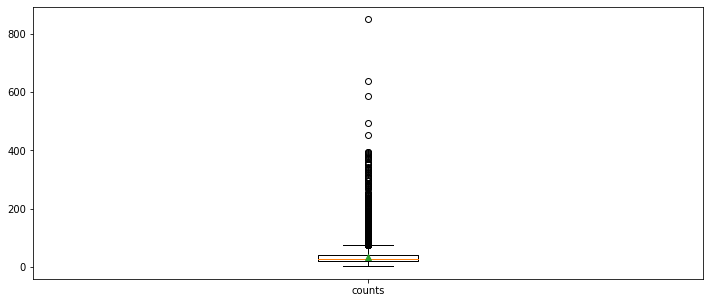

In [27]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_bert_token_counts,
             labels=['counts'],
             showmeans=True)

이처럼 EDA를 통해 데이터에 대한 이해도를 높인 후 모델에 필요한 최대 길이 값을 선정한다.